# Variance decomposition of sea level change

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
exp_path = '/home/jt1187/facts/myexperiments'

## Bob's old datasets
#rootdir = '/projects/kopp/facts-experiments/'
#exp_date  = 221217
#exp_path = os.path.join(rootdir,str(exp_date))

# List of scenarios to load
scenarios = ['ssp585']

# List of components and corresponding module to be used
components = ['AIS','GrIS_GIS','glaciers','landwaterstorage','sterodynamics','verticallandmotion']

# Pick corresponding modules (must be in the same sequence as components)
#modules = ['ipccar5', 'FittedISMIP', 'ipccar5', 'ssp' , 'tlm', 'kopp14'] # wf1f
#modules = ['larmip', 'FittedISMIP', 'ipccar5', 'ssp' , 'tlm', 'kopp14'] # wf2f
#modules = ['bamber19', 'bamber19', 'ipccar5', 'ssp' , 'tlm', 'kopp14'] # wf4

# Custom (wf2f, but use emulandice for AIS)
modules = ['emulandice', 'FittedISMIP', 'ipccar5', 'ssp' , 'tlm', 'kopp14'] 

# Global, local or both (*)
ext = '*' # global, local, *

# Variable name in netcdf files
var = 'sea_level_change'

yr_st = 2020
yr_ed = 2100

In [3]:
ddict = {s:{} for s in scenarios}
das = []
for scenario in scenarios:
    print('\n',scenario)
    head = 'coupling.%s'%scenario
    data_path = exp_path+'/'+head+'/output/'
    for i,component in enumerate(components):
        if modules[i] in ['bamber19','ipccar5']:
            if component=='AIS':
                component_str = 'icesheets_'+component if modules[i]=='bamber19' else 'icesheets_*'+component
            elif component=='GrIS_GIS':
                component_str = 'icesheets_'+component.split('_')[-1]
            else:
                component_str = component
        else:
            component_str = component   
                
        # In case of ipccar5, localsl is missing for AIS -> Get WAIS and EAIS instead
        #if (modules[i]=='ipccar5') & (component=='AIS'):
        #    print(head+'.*.%s.%s_%ssl.nc'%(modules[i],component,ext))
                
        file_str = head+'.*.%s.%s_%ssl.nc'%(modules[i],component_str,ext)
        fnames = glob.glob(data_path+file_str)
        print('\n',component)
        for fname in fnames:
            component_ext = os.path.basename(fname).split('.')[-2].split('_')
            #print(component,component_ext)
            if (component!='GrIS_GIS') & (len(component_ext)>2) & (modules[i] not in ['bamber19','ipccar5']):
                continue
            print(os.path.basename(fname))
            #print(os.path.basename(fname).split('.')[-2].split('_'))
        print(file_str)
        
        # In case of ipccar5, localsl is missing for AIS -> Get WAIS and EAIS instead
        # and derived AIS by summing sea_level_change of WAIS and EAIS
        if (modules[i]=='ipccar5') & (component=='AIS'):
            das_subcomponent = []
            for subcomponent in ['EAIS','WAIS']:
                print(subcomponent)
                print([fname for fname in fnames if subcomponent in fname])
                print()
                fnames_subcomponent = [fname for fname in fnames if subcomponent in fname]
                ds_subcomponent = xr.open_mfdataset(fnames_subcomponent)
                da_subcomponent = ds_subcomponent[var]
                attrs = {**da_subcomponent.attrs, **ds_subcomponent.attrs}
                da_subcomponent['subcomponent'] = subcomponent
                das_subcomponent.append(da_subcomponent)
                
            da = xr.concat(das_subcomponent,dim='subcomponent').sum('subcomponent').rename(component)
            da.attrs = attrs  
        else:
            ds = xr.open_mfdataset(data_path+file_str)
            da = ds[var].rename(component)
            da.attrs = {**da.attrs, **ds.attrs}
            
        # No global file for VLM. Add all-zero array instead 
        if component=='verticallandmotion':
            da_g = xr.zeros_like(da.isel(locations=0)).squeeze().reset_coords(drop=True)
            da_g = da_g.expand_dims(dim='locations')
            da_g['locations'] = xr.DataArray([-1], dims='locations')
            da = xr.concat([da_g,da], dim='locations').transpose('samples','years','locations')
        
        da.attrs['module'] = modules[i]
        das.append(da)
        
    ds = xr.merge(das)
    
    # Clear the attributes
    ds.attrs = {}
    
    # Save to ddict
    ddict[scenario] = ds


 ssp585

 AIS
coupling.ssp585.emuAIS.emulandice.AIS_localsl.nc
coupling.ssp585.emuAIS.emulandice.AIS_globalsl.nc
coupling.ssp585.*.emulandice.AIS_*sl.nc

 GrIS_GIS
coupling.ssp585.GrIS1f.FittedISMIP.GrIS_GIS_localsl.nc
coupling.ssp585.GrIS1f.FittedISMIP.GrIS_GIS_globalsl.nc
coupling.ssp585.*.FittedISMIP.GrIS_GIS_*sl.nc

 glaciers
coupling.ssp585.ar5glaciers.ipccar5.glaciers_globalsl.nc
coupling.ssp585.ar5glaciers.ipccar5.glaciers_localsl.nc
coupling.ssp585.*.ipccar5.glaciers_*sl.nc

 landwaterstorage
coupling.ssp585.lws.ssp.landwaterstorage_localsl.nc
coupling.ssp585.lws.ssp.landwaterstorage_globalsl.nc
coupling.ssp585.*.ssp.landwaterstorage_*sl.nc

 sterodynamics
coupling.ssp585.ocean.tlm.sterodynamics_localsl.nc
coupling.ssp585.ocean.tlm.sterodynamics_globalsl.nc
coupling.ssp585.*.tlm.sterodynamics_*sl.nc

 verticallandmotion
coupling.ssp585.k14vlm.kopp14.verticallandmotion_localsl.nc
coupling.ssp585.*.kopp14.verticallandmotion_*sl.nc


In [4]:
ds = ddict['ssp585'].sel(years=slice(yr_st,yr_ed))

In [5]:
sum_of_components = xr.zeros_like(ds[component]).rename('sum_of_components')
sum_of_components.attrs = {}
for v in list(ds.keys()):
    sum_of_components += ds[v]

In [6]:
ddict_var = {s:{} for s in ['raw','fraction']}

for s in ddict_var:
    das = []
    for v in list(ds.keys()):
        #print(v)
        if s=='raw':
            da = ds[v].var('samples')/1e6
        else:
            da = ds[v].var('samples')/sum_of_components.var('samples')
        
        da = da.rename(v)
        das.append(da)
        
    ddict_var[s] = xr.merge(das)

## Stackplots

In [7]:
stack_clrs = ['tab:red', 'lightseagreen', 'tab:green', 'm','royalblue','y']

### Global

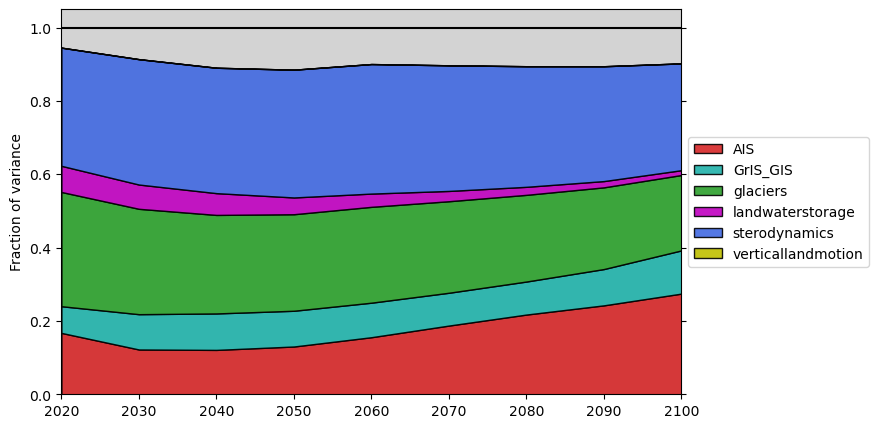

In [8]:
plot_type = 'fraction' # raw, fraction
loc_idx = -1

da_vars = ddict_var[plot_type].sel(locations=loc_idx).to_array()
yrs = da_vars.years.values
varF = da_vars.variable.values

fig, ax = plt.subplots(figsize=(8,5))
ax.stackplot(yrs, np.vstack(varF), labels=da_vars.coords['variable'].values,
             colors=stack_clrs,alpha=0.9,ec='k',lw=1)

#ax.set_ylim([0, 1.6] if plot_type=='fraction' else [None,None])

if plot_type == 'fraction':
    ax.axhline(y=1, color='black')
ax.set_xlim([2020, 2100]); 
ax.set_ylabel('Fraction of variance' if plot_type=='fraction' else 'Raw variance')
ax.tick_params(axis='both', labelsize=10)
ax.yaxis.set_ticks_position('both')
ax.set_facecolor('lightgrey')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Local

In [9]:
# Load location file
df_loc = pd.read_csv('/home/jt1187/facts/input_files/location.lst', header=None, sep='\t',
                     names=['name', 'id', 'lat', 'lon'])

# Remove the rows that start with "grid_" in the name column
df_loc = df_loc[~df_loc['name'].str.startswith("grid_")]

In [10]:
#locs = ['WILMINGTON','FORT_MYERS','NEW_YORK']
#locs = ['BAR_HARBOR','NEW_YORK','WILMINGTON','FORT_MYERS']
locs = ['BAR_HARBOR','NEW_YORK','WILMINGTON','FORT_MYERS',
        'BERGEN', 'DUBLIN', 'DOVER', 'BREST',
        'MIYAKO_I', 'KUSHIMOTO', 'BUSAN', 'KANMEN']

df_loc[df_loc['name'].isin(locs)]

,name,id,lat,lon
0,BREST,1,48.38,-4.49
9,NEW_YORK,12,40.70,-74.01
43,BERGEN,58,60.40,5.32
96,KUSHIMOTO,134,33.48,135.77
174,DOVER,255,51.11,1.32
239,WILMINGTON,396,34.23,-77.95
263,DUBLIN,432,53.35,-6.22
284,MIYAKO_I,463,39.63,141.97
324,BAR_HARBOR,525,44.39,-68.20
547,KANMEN,934,28.08,121.28


In [11]:
locations = list(df_loc[df_loc['name'].isin(locs)].id.values)

In [12]:
n = len(locations)

# Calculate the number of columns
ncols = int(np.ceil(np.sqrt(n)))

# Calculate the number of rows
nrows = int(np.ceil(n / ncols))

if n <= 2:
    figsize = (8, 4)
else:
    figsize = (18,12)

/home/jt1187/miniconda3/envs/facts/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


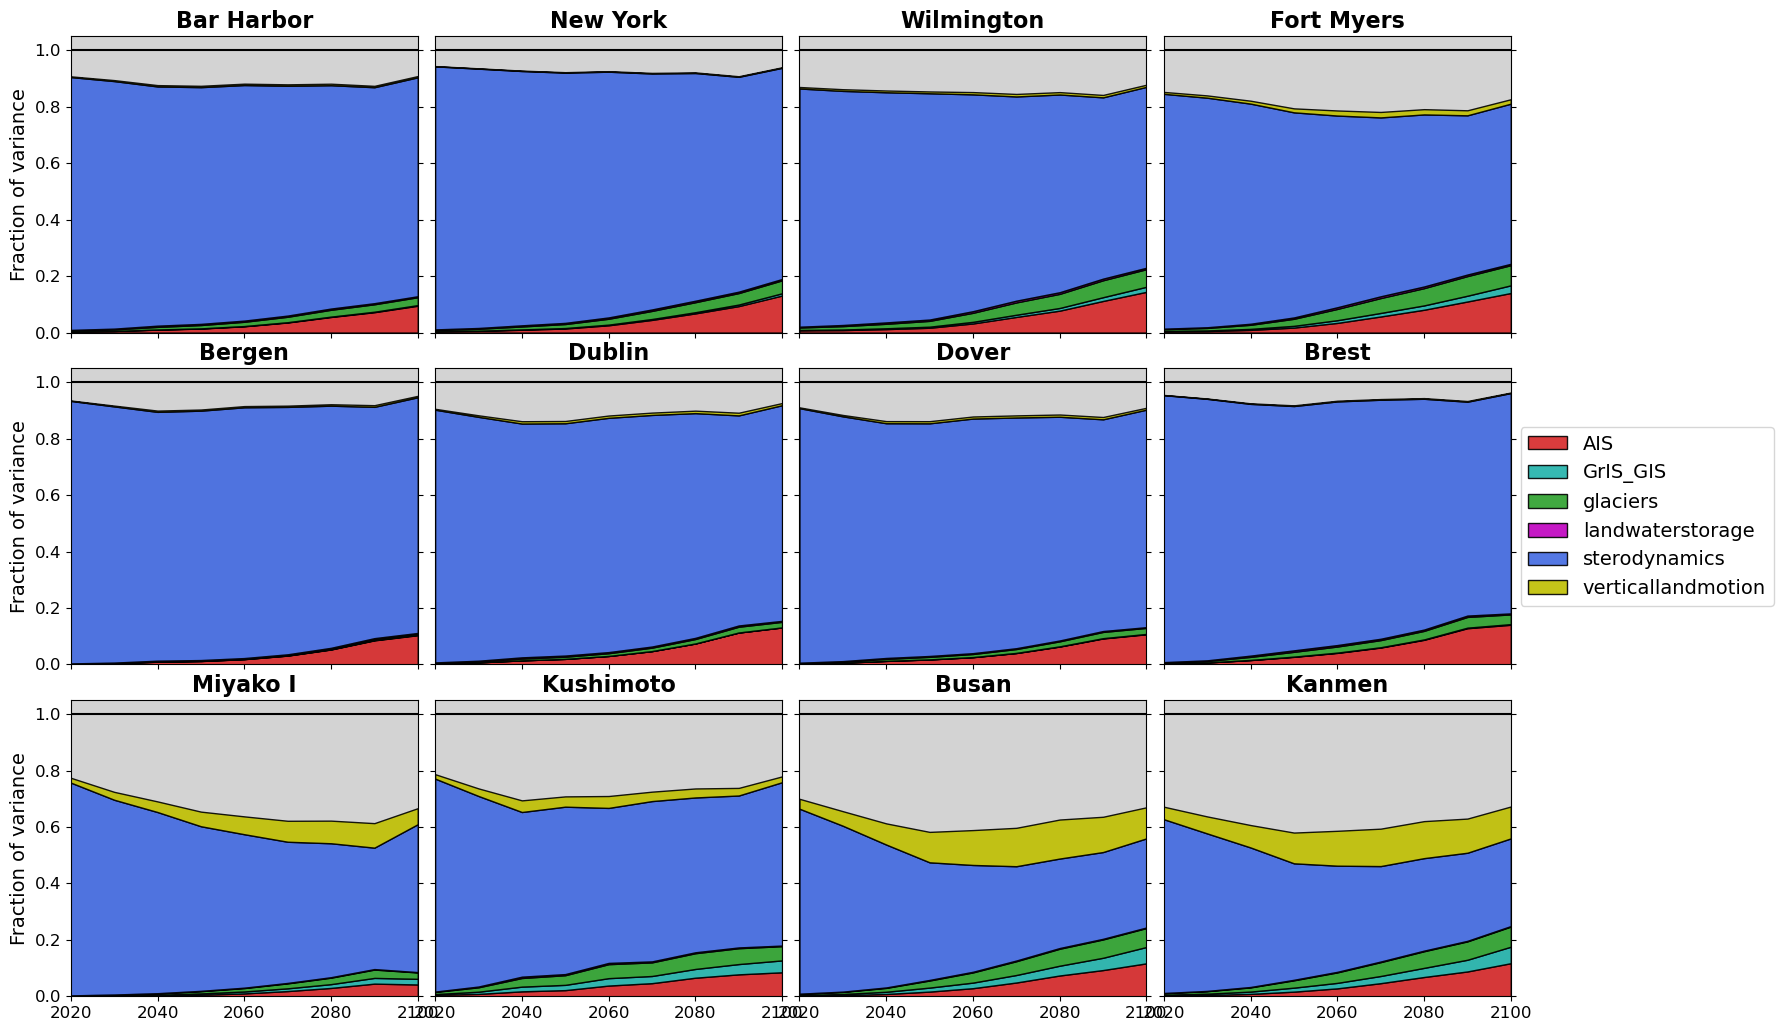

In [13]:
plot_type = 'fraction' # raw, fraction

fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=figsize)
fig.subplots_adjust(left=0.1, right=0.90, bottom=0.1, top=0.9, hspace=0.12, wspace=0.05)
axs = axs.flatten()

for i, loc in enumerate(locs):
    loc_idx = df_loc[df_loc['name']==loc].id.values[0]
    da_vars = ddict_var[plot_type].sel(locations=loc_idx).to_array()
    yrs = da_vars.years.values
    varF = da_vars.variable.values
    
    ax = axs[i] if n>1 else axs
    p = ax.stackplot(yrs, np.vstack(varF), labels=da_vars.coords['variable'].values,
                     colors=stack_clrs,alpha=0.9,ec='k',lw=1)
    
    #ax.set_ylim([0, 1.6] if plot_type=='fraction' else [None,None])
    ax.axhline(y=1, color='black')
    ax.set_xlim([2020, 2100])
    if i % ncols == 0:
        ax.set_ylabel('Fraction of variance' if plot_type=='fraction' else 'Raw variance', fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.yaxis.set_ticks_position('both')
    ax.set_facecolor('lightgrey')
    ax.set_title(df_loc[df_loc.id==loc_idx].name.values[0].replace('_',' ').title(), fontsize=16, fontweight='bold')
    
# Add a single legend to the figure
fig.legend(handles=p, loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=14)
plt.savefig('/home/jt1187/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Map

In [14]:
import cartopy

In [15]:
varF_TE = ddict_var['fraction'].sel(years=2100).sterodynamics

In [16]:
df_varF = varF_TE.isel(locations=slice(1,None)).reset_coords(drop=True).to_dataframe().reset_index()\
            .rename(columns={'locations': 'id'})

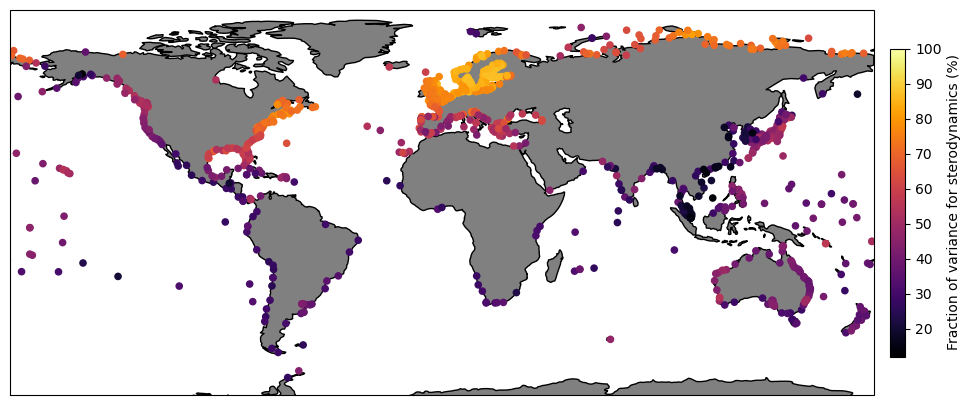

In [17]:
fig = plt.figure(figsize=[15, 5])
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black', facecolor='grey')

p = ax.scatter(df_loc.lon.values, df_loc.lat.values, transform=cartopy.crs.PlateCarree(),
               c=df_varF.sterodynamics.values*100, s=20, vmin=12, vmax=100,cmap='inferno')

# Add separate colorbar
cb = fig.colorbar(p, shrink=0.8, pad=0.014, orientation='vertical')
cb.set_label('Fraction of variance for sterodynamics (%)')
plt.savefig('/home/jt1187/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

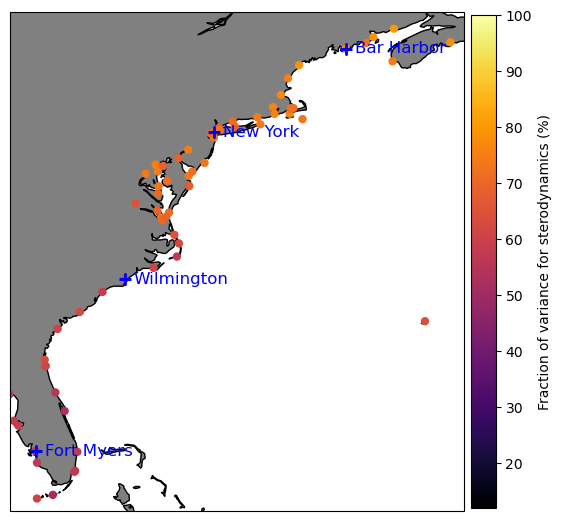

In [18]:
# US east coast
locs = ['BAR_HARBOR','NEW_YORK','WILMINGTON','FORT_MYERS']
west, east, north, south = -83.0,  -63.0, 24.0, 46.0 
fig = figsize=[7, 8]


# Europe
#locs = ['BERGEN', 'DUBLIN', 'DOVER', 'BREST']
#west, east, south, north = -13, 30, 35, 73
#figsize=[8, 7]

# East Asia coast
#locs = ['MIYAKO_I', 'KUSHIMOTO', 'BUSAN', 'KANMEN']
#west, east, south, north = 119, 150, 22, 46
#fig = figsize=[8, 6]

fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent([west, east, south, north], cartopy.crs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black', facecolor='grey')

p = ax.scatter(df_loc.lon.values, df_loc.lat.values, transform=cartopy.crs.PlateCarree(),
               c=df_varF.sterodynamics.values*100, s=25, vmin=12, vmax=100, cmap='inferno')

ax.plot(df_loc[df_loc['name'].isin(locs)].lon.values, df_loc[df_loc['name'].isin(locs)].lat.values, 
        transform=cartopy.crs.PlateCarree(), marker='+', color='b', markersize=8, linestyle='',
        markeredgewidth=2, label='Tide gauge')

# Add name for each tide gauge
for idx in range(0,len(df_loc[df_loc['name'].isin(locs)])):
    ax.text(df_loc[df_loc['name'].isin(locs)].iloc[idx].lon+0.4, df_loc[df_loc['name'].isin(locs)].iloc[idx].lat, 
            df_loc[df_loc['name'].isin(locs)].iloc[idx]['name'].replace('_',' ').title(), 
            color='b', fontsize=12, va='center', ha='left')

# Add separate colorbar
cb = fig.colorbar(p, shrink=0.8, pad=0.014, orientation='vertical')
cb.set_label('Fraction of variance for sterodynamics (%)')
plt.savefig('/home/jt1187/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [19]:
import matplotlib.ticker as mticker

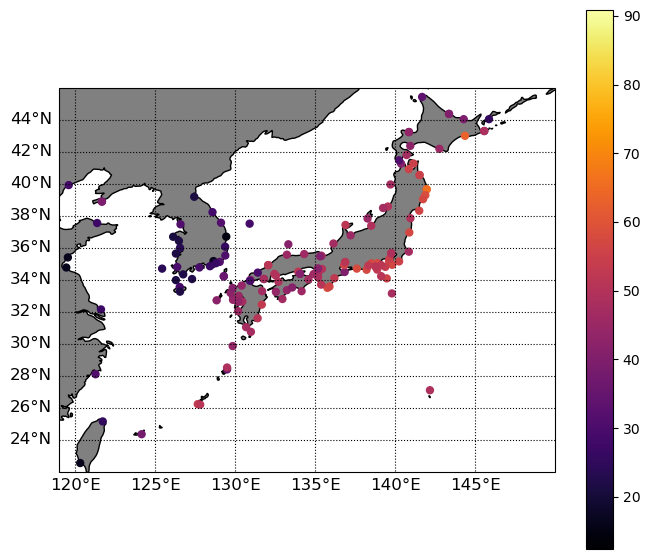

In [20]:
west, east, south, north = 119, 150, 22, 46

fig = plt.figure(figsize=[8, 7])
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent([west, east, south, north], cartopy.crs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black', facecolor='grey')
p = ax.scatter(df_loc.lon.values, df_loc.lat.values, transform=cartopy.crs.PlateCarree(),
               c=df_varF.sterodynamics.values*100, s=25,cmap='inferno')
gl = ax.gridlines(linestyle=":",color='k', draw_labels=True,x_inline=False, y_inline=False,zorder=3)
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,5))
gl.ylocator = mticker.FixedLocator(np.arange(0,100,2))
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style= {'size': 12, 'color': 'k'}
gl.ylabel_style= {'size': 12, 'color': 'k'}
fig.colorbar(p)
plt.show()

In [21]:
# Subsample the dataframe based on the lat/lon ranges
df_loc[(df_loc['lat'] >= south) & (df_loc['lat'] <= north) & (df_loc['lon'] >= west) & (df_loc['lon'] <= east)]

,name,id,lat,lon
71,TONOURA,94,34.90,132.07
92,ABURATSUBO,130,35.16,139.62
93,AYUKAWA,131,38.30,141.51
94,WAJIMA,132,37.41,136.90
95,HOSOJIMA,133,32.43,131.67
...,...,...,...,...
877,ANHEUNG,1699,36.67,126.13
911,TAKAMATSU_II,1789,34.35,134.06
912,KOBE_II,1790,34.68,135.19
936,SHIMONOSEKI_III,1830,33.92,130.93


In [22]:
df_loc[df_loc['name'].isin(locs)]

,name,id,lat,lon
9,NEW_YORK,12,40.70,-74.01
239,WILMINGTON,396,34.23,-77.95
324,BAR_HARBOR,525,44.39,-68.20
631,FORT_MYERS,1106,26.65,-81.87


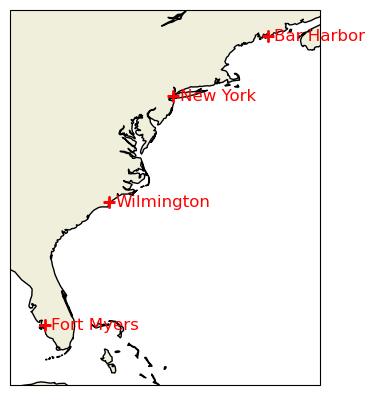

In [23]:
west, east, north, south = -84.0,  -65.0, 23.0, 46.0

fig = plt.figure(figsize=[4, 5])
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent([west, east, south, north], cartopy.crs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

ax.plot(df_loc[df_loc['name'].isin(locs)].lon.values, df_loc[df_loc['name'].isin(locs)].lat.values, 
        transform=cartopy.crs.PlateCarree(), marker='+', color='r', markersize=8, linestyle='',
        markeredgewidth=2, label='Tide gauge')

# Add name for each tide gauge
for idx in range(0,len(df_loc[df_loc['name'].isin(locs)])):
    ax.text(df_loc[df_loc['name'].isin(locs)].iloc[idx].lon+0.4, df_loc[df_loc['name'].isin(locs)].iloc[idx].lat, 
            df_loc[df_loc['name'].isin(locs)].iloc[idx]['name'].replace('_',' ').title(), 
            color='r', fontsize=12, va='center', ha='left')
plt.show()

### Plot fraction of variance across locations

/home/jt1187/miniconda3/envs/facts/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/jt1187/miniconda3/envs/facts/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


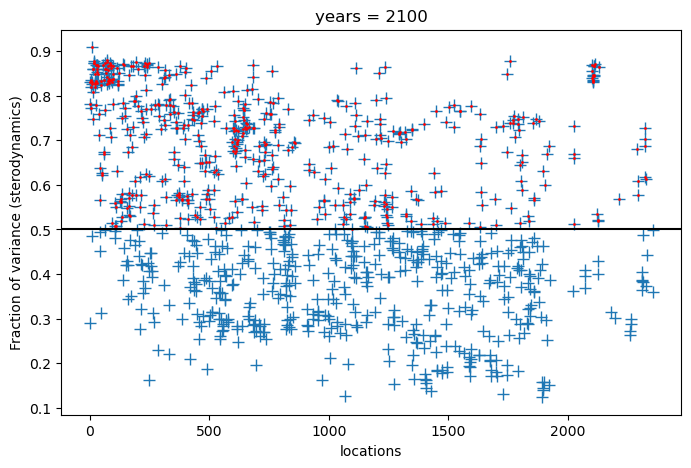

In [24]:
frc_threshold = 0.5
fig, ax = plt.subplots(figsize=(8,5))
ddict_var['fraction'].sel(years=2100).sterodynamics.plot(ax=ax,marker='+',ms=8, linestyle='')
varF_TE.where(varF_TE>frc_threshold).plot(ax=ax,marker='o',ms=1, linestyle='',c='r')
ax.axhline(y=frc_threshold, color='black')
ax.set_ylabel('Fraction of variance (sterodynamics)')
plt.show()

In [25]:
locations = list(varF_TE.where(varF_TE>frc_threshold, drop=True).locations.values)

/home/jt1187/miniconda3/envs/facts/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


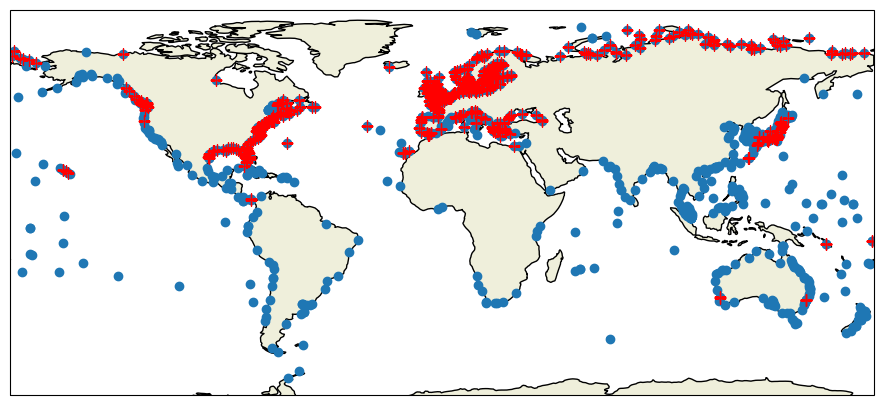

In [26]:
fig = plt.figure(figsize=[15, 5])
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

ax.plot(df_loc.lon.values, df_loc.lat.values, transform=cartopy.crs.PlateCarree(), marker='o', linestyle='')
ax.plot(df_loc[df_loc['id'].isin(locations)].lon.values, df_loc[df_loc['id'].isin(locations)].lat.values, 
        transform=cartopy.crs.PlateCarree(), marker='+', color='r', markersize=8, linestyle='',
        markeredgewidth=1)
plt.show()